## Import necessary python libraries

In [1]:
import feyn
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
import warnings
warnings.filterwarnings('ignore')
feyn._qlattice._USE_V2_API = True
import collections
import os

In [2]:
from _crossvalidation import *

In [3]:
class ModelResults:
    def __init__(self, kind="classification"):
        self.kind = kind

        if self.kind == "classification":
            self.df = pd.DataFrame(columns=['model_structure', 'fold', 'aic', 'bic', 'roc_auc', 'accuracy', 'pr_auc',
                                            'f1'])
        elif self.kind == "regression":
            self.df = pd.DataFrame(columns=['model_structure', 'fold', 'aic', 'bic', 'rmse', 'mae', 'r2_score'])
        else:
            raise ValueError("kind must be classification or regression")

    def update(self, train, val, fold, model):
        if model:
            if self.kind == "classification":
                model_precision, model_recall, _ = precision_recall_curve(val[model.output], model.predict(val))
                if model:
                    self.df = self.df.append(pd.DataFrame(data={
                        'model_structure': [str(model.sympify(include_weights=False))],
                        'fold': [fold],
                        'aic': [model.aic],
                        'bic': [model.bic],
                        'roc_auc': [model.roc_auc_score(val)],
                        'accuracy': [model.accuracy_score(val)],
                        'pr_auc': [auc(model_recall, model_precision)],
                        'f1': [f1_score(val[model.output], model.predict(val) > model.accuracy_threshold(train)[0])]
                    }))

            elif self.kind == "regression":
                if model:
                    preds = model.predict(val)
                    self.df = self.df.append(pd.DataFrame(data={
                        'model_structure': [str(model.sympify(include_weights=False))],
                        'fold': [fold],
                        'aic': [model.aic],
                        'bic': [model.bic],
                        'rmse': [feyn.metrics.rmse(val[model.output], preds)],
                        'mae': [feyn.metrics.mae(val[model.output], preds)],
                        'r2_score': [feyn.metrics.r2_score(val[model.output], preds)]
                    }))




In [4]:
feyn.__version__

'2.1.1'

## Load necessary files

In [5]:
expression_table = '../data/insulin_dataset.csv'
data_togo = pd.read_csv(expression_table, sep=',')


In [6]:
data_togo.head()

,Cond,7SK,A1BG,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-3180-3,hsa-mir-3180-4,hsa-mir-6080,hsa-mir-8072,Class_,CV_Split
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,14.70225,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,17.32925,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,41.75375,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,25.87975,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,60.01325,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0


In [7]:
# make dictionary to store original features names
features_dict = dict()
for genes_names in data_togo.columns:
    qlattice_gene_names = genes_names.replace(".", "_").replace(".", "_")
    features_dict[qlattice_gene_names] = genes_names

## Standardise feature names

In [8]:
data_togo.columns = data_togo.columns.str.replace(".", "_")
data_togo.columns = data_togo.columns.str.replace("-", "_")

In [9]:
data_togo

,Cond,7SK,A1BG,A2M,A2M_AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZYX,ZZEF1,ZZZ3,hsa_mir_1199,hsa_mir_3180_3,hsa_mir_3180_4,hsa_mir_6080,hsa_mir_8072,Class_,CV_Split
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,14.70225,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,17.32925,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,41.75375,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,25.87975,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,60.01325,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,NO77h2,81.744,3.071,19.550250,11.340,3.6620,25.5155,26.933,106.787,2.2445,...,19.13675,35.674,12.2855,2.5990,1.7720,0.236,0.473,1.890,1.0,4.0
134,NO89f0,75.857,2.423,8.565000,6.664,47.7895,28.3035,4.981,6.664,0.9090,...,43.80125,65.761,4.6440,7.2695,3.5675,1.750,1.010,4.981,0.0,0.0
135,NO89f2,308.708,2.424,21.948313,2.277,6.9425,33.7580,5.877,74.349,2.0940,...,26.08100,25.934,10.1385,3.1590,1.4695,1.102,0.882,1.837,0.0,0.0
136,NO89h0,151.748,2.106,6.307750,7.538,56.1985,26.9635,22.668,7.039,1.8845,...,37.36900,62.462,4.3785,5.9580,4.8770,2.605,1.275,6.595,1.0,0.0


## Training a QLattice in a cross-validation scheme as framework


In [10]:
logdir='../models_insulin_paper/'
os.makedirs(logdir, exist_ok=True)


partitions_interval = np.arange(5)
inner_partitions_interval = partitions_interval#[partitions_interval != 4]

results = ModelResults()


for val_partition in inner_partitions_interval:
    os.makedirs('%spartition_%i' % (logdir, val_partition), exist_ok=True)
    model_file = "%spartition_%i/model" % (logdir, val_partition)
    train = data_togo.loc[(data_togo.CV_Split != val_partition)]
    val = data_togo.loc[(data_togo.CV_Split == val_partition)]
    
    # Connecting to the QLattice
    
    ql = feyn.connect_qlattice()

    # Setting a seed
    
    ql.reset(random_seed=42)  

    stypes = dict()
    for f in train.columns:
        if train[f].dtype =='object':
            stypes[f] = 'c'
            
    models_ = ql.auto_run(data=train,
                          output_name="Class_",
                          kind="classification",
                          n_epochs=50,
                          max_complexity=5,
                          stypes=stypes,
                          criterion="bic",
                 )
    
    for j in models_:
        results.update(train, val, val_partition, j)
    
    for i in range(len(models_)):    
        models_[i].save(model_file+'_'+str(val_partition)+'_'+str(i)+'.json')

In [11]:
results.df

,model_structure,fold,aic,bic,roc_auc,accuracy,pr_auc,f1
0,logreg(CATG000001159511 + CDKN1A + RNASEL),0,38.451060,43.815322,0.937778,0.833333,0.934414,0.827586
0,logreg(PLAUR + RABIF + THRSP),0,41.350480,46.714742,0.977778,0.900000,0.979951,0.888889
0,logreg(C8orf4 + HMGCS1 + KLF13),0,45.638576,51.002839,0.897778,0.866667,0.936341,0.857143
0,logreg(exp(CCNT2 + SPRY4)),0,48.259324,53.623587,0.942222,0.933333,0.957888,0.933333
0,logreg(DCUN1D4 + LATS2 + PDK4),0,48.499604,53.863866,0.982222,0.933333,0.980804,0.967742
0,logreg(PHF23 + SLC25A44 + TRHDEAS1),0,48.905975,54.270237,1.000000,0.966667,1.000000,0.928571
0,logreg(CATG000000820061 + NFIL3),0,52.330483,55.012614,0.928889,0.933333,0.907039,0.933333
0,logreg(LDHD + PPP1R3B),0,52.602624,55.284755,0.960000,0.866667,0.968344,0.866667
0,logreg(BHLHE41 + INSIG1),0,52.953144,55.635275,0.973333,0.900000,0.976430,0.888889
0,logreg(HEXIM1 + NFYC + SREBF1),0,51.858989,57.223252,0.968889,0.966667,0.978283,0.965517


## Training a QLattice in train-test split mode for final model choice



In [12]:
#for i in range(len(models_)):
#    models_[i].show()


In [13]:
logdir='../models_insulin_paper_train_test/'
os.makedirs(logdir, exist_ok=True)

results_train_test = ModelResults()
os.makedirs('%spartition_%i' % (logdir, 1), exist_ok=True)
model_file = "%spartition_%i/model" % (logdir, 1)
train = data_togo.loc[(data_togo.CV_Split != 4)]
test = data_togo.loc[(data_togo.CV_Split == 4)]

# Connecting to the QLattice

ql = feyn.connect_qlattice()

# Setting a seed

ql.reset(random_seed=42)  

stypes = dict()
for f in train.columns:
    if train[f].dtype =='object':
        stypes[f] = 'c'

models_ = ql.auto_run(data=train,
                      output_name="Class_",
                      kind="classification",
                      n_epochs=50,
                      max_complexity=5,
                      stypes=stypes,
                      criterion="bic",
             )

for j in models_:
    results_train_test.update(train, test, 1, j)

for i in range(len(models_)):    
    models_[i].save(model_file+'_'+str(1)+'_'+str(i)+'.json')

In [14]:
results_train_test.df

,model_structure,fold,aic,bic,roc_auc,accuracy,pr_auc,f1
0,logreg(AC1008023 + CEBPD + SPRY4),1,43.030742,48.431702,0.989796,0.892857,0.989770,0.888889
0,logreg(ABLIM1 + HEXIM1 + LRRC8B),1,43.642925,49.043886,1.000000,0.964286,1.000000,0.923077
0,logreg(PHF2*(MIPOL1 + PDK4)),1,45.174504,53.275945,1.000000,0.964286,1.000000,0.933333
0,logreg(NFIL3 + PMP22 + ZC3H12A),1,50.024774,55.425735,1.000000,0.964286,1.000000,0.965517
0,logreg(ARHGDIG + PDK4 + PRRC2A),1,51.019631,56.420592,1.000000,0.928571,1.000000,0.965517
0,logreg(RARG + RNVU19 + USP33),1,53.686710,59.087671,1.000000,0.928571,1.000000,0.880000
0,logreg(LRP8 + log(C10orf10)),1,55.875421,61.276381,0.979592,0.892857,0.980910,0.933333
0,logreg(log(CATG000000409801 + NFIL3)),1,56.987802,62.388763,0.969388,0.857143,0.963466,0.727273
0,logreg(SREBF1*(SEZ6 + SGK1)),1,54.828153,62.929594,0.994898,0.964286,0.995068,0.965517
0,logreg(KLC2 + SPRY4),1,61.425979,64.126459,1.000000,1.000000,1.000000,1.000000


In [15]:
#models_[0].plot_response_2d(test)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 741 232.0" width="741" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>Class_
logistic:
w=-2.3166
bias=-0.0243</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">Class_</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>PDK4
linear:
scale=0.005801
scale offset=128.505173
w=-1.788602
bias=-1.1654</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">PDK4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>MIPOL1
linear:
scale=0.275330
scale offset=3.529164
w=0.787737
bias=0.9677</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">MIPOL1</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>PHF2
linear:
scale=0.498795
scale offset=1.679852
w=2.820700
bias=-4.3085</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">PHF2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="471" y="0"><defs /><text fill="#1E1E1E" font-family="monospace" font-s
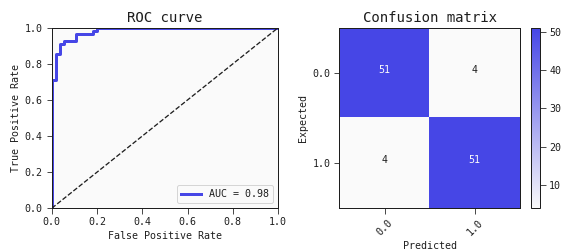
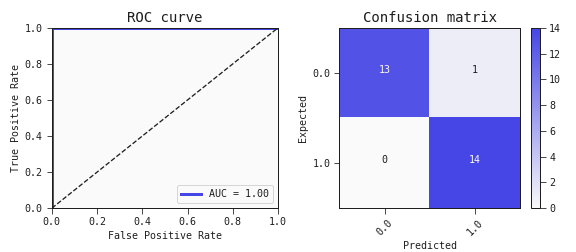

In [34]:
models_[2].plot(train,test)

In [28]:
feat_list = list()
for i in range(len(models_)):
    genes = models_[i].features
    for gene in genes:
        if gene in features_dict.keys():
            feat_list.append(features_dict[gene])

In [29]:
count_features = collections.Counter(feat_list)
count_features_df = pd.DataFrame(count_features.items(),columns=['Gene', 'Count']).sort_values('Count', ascending=False)

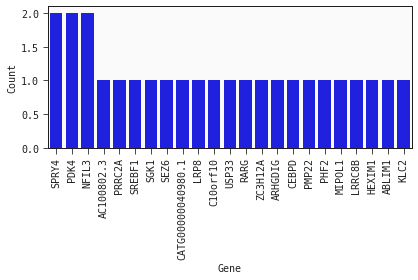

In [30]:
sns.barplot(x=count_features_df.Gene,y=count_features_df.Count, color='blue')
plt.xticks(rotation=90)
plt.tight_layout()

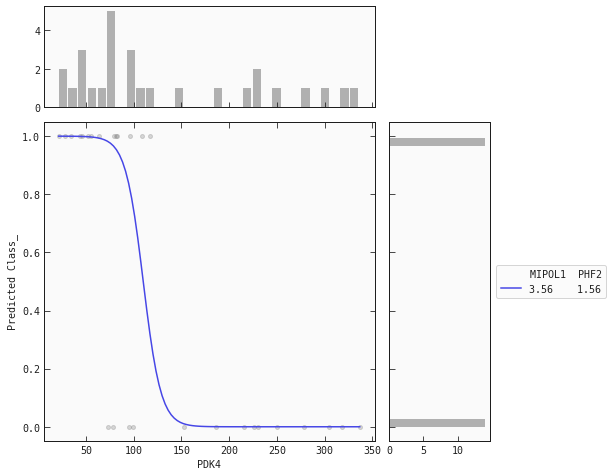

In [35]:
models_[2].plot_response_1d(test, 'PDK4')